In [1]:
import pandas as pd

In [2]:
file_path = "/jf-training-home/NLP_Model/datasets_ro/merged_data.csv"

df_merged = pd.read_csv(file_path, encoding='utf-8', sep=',')

In [3]:
print(df_merged)

                                                     text  label
0       현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네      1
1          한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요      0
2       못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...      1
3                        12화 어설펐는데 34화 지나서부터는 갈수록 너무 재밌던데      0
4         1 사람 얼굴 손톱으로 긁은것은 인격살해이고2 동영상이 몰카냐 메걸리안들 생각이 없노      1
...                                                   ...    ...
207891            오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
207892       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 oooo      0
207893                    그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다      0
207894         절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네      0
207895                                         마무리는 또 왜이래      0

[207896 rows x 2 columns]


In [5]:
# 결과 출력
print(type(df_merged))

<class 'pandas.core.frame.DataFrame'>


### 훈련 및 테스트 셋 분할

In [5]:
print(df_merged.columns)

Index(['text', 'label'], dtype='object')


In [6]:
print(df_merged['text'])
df_merged['text'] = df_merged['text'].astype(str)


0         현재 호텔주인 심정 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네
1            한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요
2         못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...
3                          12화 어설펐는데 34화 지나서부터는 갈수록 너무 재밌던데
4           1 사람 얼굴 손톱으로 긁은것은 인격살해이고2 동영상이 몰카냐 메걸리안들 생각이 없노
                                ...                        
207891              오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
207892         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 oooo
207893                      그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
207894           절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네
207895                                           마무리는 또 왜이래
Name: text, Length: 207896, dtype: object


### 훈련 및 테스트셋 분할

In [7]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_merged['text'].tolist(), df_merged['label'].tolist(), test_size=0.1, random_state=42
)

### 데이터셋 및 데이터 로더 생성

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


train_encodings = tokenizer.batch_encode_plus(
    train_texts, add_special_tokens=True, max_length=160, padding='max_length', truncation=True, return_tensors='pt'
)
test_encodings = tokenizer.batch_encode_plus(
    test_texts, add_special_tokens=True, max_length=160, padding='max_length', truncation=True, return_tensors='pt'
)

### 모델, 옵티마이저, 손실 함수 정의 및 평가 함수

In [9]:
import torch
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 옵티마이저 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

### 데이터셋 및 데이터 로더 생성

In [10]:
from util.koreanHateSpeechDataset import KoreanHateSpeechDataset
from torch.utils.data import DataLoader

# 데이터셋 생성
train_dataset = KoreanHateSpeechDataset(train_encodings, train_labels)
test_dataset = KoreanHateSpeechDataset(test_encodings, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


### 모델 학습 및 훈련

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from util.evaluate import evaluate
import torch.nn.functional as F

num_epochs = 10
losses = []
accuracies = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)
        optimizer.zero_grad()

        outputs = model(input_ids, labels=labels)
        loss =  F.cross_entropy(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    avg_loss = total_loss / len(train_loader)
    test_accuracy = evaluate(model, test_loader)
    accuracies.append(test_accuracy)
    losses.append(avg_loss)
    # 출력: 각 epoch에서의 accuracy와 loss
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 학습이 완료된 후 모델 저장
# torch.save(model.state_dict(), '/jf-training-home/NLP_Model/src/models/checkpoints/model.pth')    /



Epoch 2/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 1/10 - Loss: 0.4397, Test Accuracy: 0.8288


Epoch 3/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 2/10 - Loss: 0.3508, Test Accuracy: 0.8448


Epoch 4/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 3/10 - Loss: 0.3139, Test Accuracy: 0.8510


Epoch 5/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 4/10 - Loss: 0.2829, Test Accuracy: 0.8556


Epoch 6/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 5/10 - Loss: 0.2562, Test Accuracy: 0.8569


Epoch 7/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 6/10 - Loss: 0.2307, Test Accuracy: 0.8550


Epoch 8/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 7/10 - Loss: 0.2067, Test Accuracy: 0.8579


Epoch 9/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 8/10 - Loss: 0.1850, Test Accuracy: 0.8530


Epoch 10/10:   0%|          | 0/1462 [00:00<?, ?it/s]                       

Epoch 9/10 - Loss: 0.1648, Test Accuracy: 0.8547


Epoch 10/10 - Loss: 0.1465, Test Accuracy: 0.8591


Confusion Matrix:
[[9014 1441]
 [1488 8847]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     10455
           1       0.86      0.86      0.86     10335

    accuracy                           0.86     20790
   macro avg       0.86      0.86      0.86     20790
weighted avg       0.86      0.86      0.86     20790



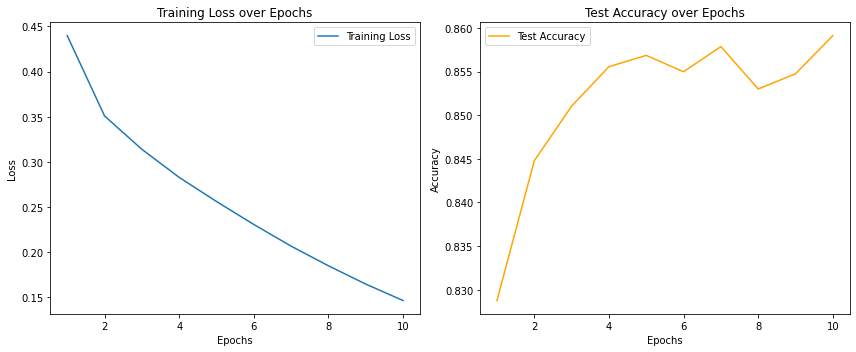

In [12]:
from sklearn.metrics import confusion_matrix, classification_report


# 테스트 데이터에서의 예측값과 실제값을 가져와서 혼동 행렬 계산
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 혼동 행렬 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 출력: 혼동 행렬과 성능 지표
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

# Plotting the loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()